In [1]:
! pip install numpy matplotlib pandas --no-index

Ignoring indexes: https://pypi.python.org/simple


In [2]:
from functools import partial

# Importing Spark packages and creating a Spark context - Importation de Spark et création d'un contexte Spark

We will use a Spark cluster made of 8 nodes, 8 cores per node, 24 GB per node. This will allow us to analyze a much bigger dataset than in the Pandas version.

---
Nous utiliserons un cluster Spark constitué de 8 noeuds, 8 coeurs de calcul par noeud, et 24 Go de mémoire par noeud. Ceci nous permettra d'analyser un jeu de données beaucoup plus gros que dans la version Pandas. 

In [3]:
import time
import pyspark
import pyspark.sql as sql
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import regexp_extract
filter_users=None

import os
MASTER_NODE = "r106-n16"
conf = pyspark.SparkConf().setMaster("spark://{}:7077".format(MASTER_NODE))\
                          .set('spark.executor.memory', '20g')\
                          .set('spark.executorEnv.PATH', os.environ['PATH'])\
                          .set('spark.executorEnv.LD_LIBRARY_PATH', os.environ['LD_LIBRARY_PATH'])\
                          .set('spark.driver.memory', '3g')

sc = pyspark.SparkContext(conf=conf)
sqlctx = sql.SQLContext(sc)

# Function to read data - Fonction pour lire les données
We are reading the same data than in the Pandas version. However, because data in a compressed form cannot be easily read in parallel, we have uncompressed them. Moreover, we will only read the columns that are required, rather than reading all columns and then discarding some. 

The format of the data remains the same from the Pandas version. They are in a "key=value" format, where pairs of key-value are separated by spaces. 

---
Nous lisons les mêmes données que dans la version Pandas. Cependant, étant donné que des données compressées sont difficile à lire en parallèle, nous utilisons une version non-compressée des données. De plus, nous lirons uniquement les colonnes requises, plutôt que de supprimer les colonnes non-requises. 

Le format demeure le même, soit un format "clé=valeur" où les paires de clé-valeur sont séparées par des espaces. 

In [4]:
def read_log_line(line, columns, csv_sep, kv_sep):
    record = {}
    try: 
        for kv in line.split(csv_sep):
            try:
                key, value = kv.split(kv_sep, 1)
            except ValueError:
                continue
            record[key] = value
    except ValueError:
        return [None for col in columns]
    return [record.get(col, None) for col in columns]

# Functions to calculate derivated data - Fonctions pour calculer des données dérivées
Compared to the Pandas version, we have fewer function to compute derivated data. This is because we will use Spark's built-in functions to make much of the calculation. We also need to convert the functions into Spark "UDF" (user-defined functions). 

---
Comparativement à la version Pandas, nous avons besoin de moins de fonctions pour calculer les données dérivées. La raison est que nous utiliserons des fonctions incluses directement dans Spark pour la plupart des calculs. Nous devons aussi convertir les fonctions en "UDF" (user-defined function) Spark.

In [5]:
import re

def walltime_to_seconds(instr):
    if instr is None:
        return None
    
    data = instr.split(":")
    return sum(mul*int(val) for mul, val in zip([1, 60, 60**2, 24*60**2], reversed(data)))

def memory_str_to_memory_gb(instr):
    if instr is None:
        return None
    
    m = re.search("(\d+)([kKmMgGtTpP])[bB]", instr)
    factors = {'k': 1./1024**2, 'm' : 1./1024, 'g': 1., 't' : 1024., 'p' : 1024.**2}
    if m:
        num = int(m.group(1))
        unit = m.group(2).lower()
        return num * factors[unit]
    return None

# UDF functions require a Spark SQL Context, otherwise they create a dummy one.
udf_walltime_to_seconds = sql.functions.udf(walltime_to_seconds, sql.types.IntegerType())
udf_memory_str_to_memory_gb = sql.functions.udf(memory_str_to_memory_gb, sql.types.FloatType())

# Calculating derivated data - Calcul des données dérivées
Using the functions above and Spark functions, we define multiple new fields, which will be calculated based on the original data. 

---
En utilisant les fonctions ci-dessus et des fonctions Spark, nous définissons plusieurs nouveaux champs, qui seront calculés à partir des données originales. 

In [6]:
def compute_data(df,default_ppn=None):
    df = df.withColumn('node_count', regexp_extract('Resource_List_nodes', '(^\d+)[^0-9]*', 1).cast(IntegerType()))
    df = df.withColumn('ppn', regexp_extract('Resource_List_nodes', 'ppn=(\d+)', 1).cast(IntegerType()))
    if default_ppn:
        df = df.na.fill(value=default_ppn, subset='ppn')
    df = df.withColumn("total_cores", df["node_count"]*df["ppn"])
    df = df.withColumn('gpupn', regexp_extract('Resource_List_nodes', 'gpus=(\d+)', 1).cast(IntegerType()))
    df = df.withColumn("total_gpus", df["node_count"]*df["gpupn"])
    
    df = df.withColumn("req_walltime", udf_walltime_to_seconds(df["Resource_List_walltime"]))
    df = df.withColumn("req_memory_gb", udf_memory_str_to_memory_gb(df["Resource_List_mem"]))
    df = df.withColumn("req_cput", df["req_walltime"]*df["total_cores"])
    
    df = df.withColumn("used_memory_gb", udf_memory_str_to_memory_gb(df["resources_used_mem"]))
    df = df.withColumn("used_walltime", udf_walltime_to_seconds(df["resources_used_walltime"]))
    df = df.withColumn("used_cput", udf_walltime_to_seconds(df["resources_used_cput"]))
       
    df = df.withColumn("used_walltime_hours", sql.functions.round(df["used_walltime"]/3600))
    df = df.withColumn("req_walltime_hours", sql.functions.round(df["req_walltime"]/3600))
    df = df.withColumn("wasted_walltime_hours",sql.functions.round((df["req_walltime"] - df["used_walltime"])/3600))
    df = df.withColumn("walltime_accuracy", df["used_walltime"]/df["req_walltime"])
    df = df.withColumn("used_memory_gb_integer", df["used_memory_gb"].cast(sql.types.IntegerType()))
    df = df.withColumn("effective_cores", df["used_cput"]/df["used_walltime"])
    df = df.withColumn("used_memory_gb_per_eff_core", df["used_memory_gb"]/df["effective_cores"])
    df = df.withColumn("used_memory_gb_per_req_core", df["used_memory_gb"]/df["total_cores"])
    df = df.withColumn("efficiency", df["effective_cores"]/df["total_cores"])
    
    df = df.withColumn("dedicated_core_seconds", df["used_walltime"]*df["total_cores"])
    df = df.withColumn("dedicated_gpu_seconds", df["used_walltime"]*df["total_gpus"])
    return df

# Calculating weighted histograms - Calcul des histogrammes avec poids
Unfortunately, Spark does not allow us to generate weithed histograms out of the box. We therefore have to write a function to do so ourselves. Given a range, the function whistogram will generate bins for a histogram, based on the weights column. 

---
Malheureusement, Spark ne nous permet pas de générer des histogrammes avec poids nativement. Nous devons donc écrire une fonction pour générer ces données. Étant donné un intervalle de calcul, la fonction whistogram va générer des boîtes d'histogramme, à partir de la colonne de poids. 

In [7]:
import numpy
def whistogram(rdd, weights, bins, range_=None, normed=True):
    if bins < 1:
        raise ValueError("number of buckets must be >= 1")

    # faster than stats()
    if range_ is None:
        def minmax(a, b):
            return min(a[0], b[0]), max(a[1], b[1])
        try:
            minv, maxv = rdd.map(lambda x: (x, x)).reduce(minmax)
        except TypeError as e:
            if " empty " in str(e):
                raise ValueError("can not generate buckets from empty RDD")
            raise
    else:
        minv, maxv = range_

    if minv == maxv or bins == 1:
        return [minv, maxv], [rdd.count()]

    try:
        inc = (maxv - minv) / bins
    except TypeError:
        raise TypeError("Can not generate buckets with non-number in RDD")

    if numpy.isinf(inc):
        raise ValueError("Can not generate buckets with infinite value")

    # keep them as integer if possible
    inc = int(inc)
    if inc * bins != maxv - minv:
        inc = (maxv - minv) * 1.0 / bins

    buckets = [i * inc + minv for i in range(bins)]
    buckets.append(maxv)  # fix accumulated error

    def histogram(iterator):
        counters = [0] * len(buckets)
        for i, w in iterator:
            if i is None or (type(i) is float and numpy.isnan(i)) or i > maxv or i < minv:
                continue
            t = int((i - minv) / inc)
            counters[t] += w
        # add last two together
        last = counters.pop()
        counters[-1] += last
        return counters,

    def mergeCounters(a, b):
        return [i + j for i, j in zip(a, b)]

    hist = numpy.array(rdd.zip(weights).mapPartitions(histogram).reduce(mergeCounters))

    if normed:
        hist = hist/weights.sum()
    return hist, buckets


# Computing the range - Calcul de l'intervalle
In the Pandas version, we used percentiles to generate a range for our plots. This allowed us to exclude aberrant data. Calculating percentiles on local data is relatively easy. One can simply sort the data. However, performing a sort on distributed data is a much more costly operation. Therefore, this approach is not ideal for Spark data. Instead, we can use the standard deviation, or a fixed range. 

---
Dans la version Pandas, nous avons utiliser des percentiles pour choisir l'intervalle de nos graphiques. Ceci nous a permis d'exclure les données aberrantes. Calculer des percentiles sur des données locales est relativement facile. Il s'agit de faire un tri. Cependant, trier des données distribuées est une opération beaucoup plus couteuse. Cette approche n'est donc pas adaptée pour des données avec Spark. À la place, nous utilisons la déviation standard ou un intervalle prédéfini. 

In [8]:
def compute_perc_usage(df, col, col_weights, bins=None, quantile=None, num_std=None, in_range=None, in_min=None, in_max=None, range_type="graph"):
    not_null = df[df[col].isNotNull() & df[col_weights].isNotNull()]
    data_rdd = not_null.select(col).rdd.map(lambda x: x[0])
    weights_rdd = not_null.select(col_weights).rdd.map(lambda x: x[0])
    
    min_ = data_rdd.min()
    max_ = data_rdd.max()
    
    if in_range:
        min_range, max_range = in_range
        min_range = max(min_, min_range)
        max_range = min(max_, max_range)
    elif num_std:
        mean_ = data_rdd.mean()
        std_ = data_rdd.sampleStdev()        
        min_range, max_range = max(min_,mean_ - num_std*std_), min(max_,mean_+num_std*std_)
    elif quantile:
        min_range, max_range = data_rdd.min(), not_null.approxQuantile(col, [quantile], 0.0001)[0]
    else:
        min_range, max_range = None, None

    if min_range is None or (min_range is not None and in_min is not None and min_range < in_min):
        min_range = in_min
    if max_range is None or (max_range is not None and in_max is not None and max_range > in_max):
        max_range = in_max

    
    if min_range is not None and max_range is not None:
        range_ = min_range, max_range
    else:
        range_ = None
   
    if bins is None:
        bins = 100

    hist, bin_edges = whistogram(data_rdd, weights_rdd, range_=range_, bins=bins, normed=True)    

    return hist, bin_edges



# Function to create a plot - Fonction pour créer un graphique
We are usually interested to answer the following question: "What percentage of the workload requires X amount of resources ?"

To answer this question, we plot histograms for which the weight of each bin is given by the number of core-seconds of the job. We show both the regular histogram and the integrated (or cumulative) histogram. The regular histogram answers the question "What percentage of the workload requires exactly X amount of resources ?" while the cummulative histogram answers the question "What percentage of the workload requires X or less resources ?". 

--- 
Nous sommes généralement intéressés répondre à la question suivante: "Quel pourcentage du temps de calcul nécessite X ressources ?"

Pour ce faire, nous traçons des histogrammes dont le poids des barres est donné par le nombre de coeurs-secondes de la tâche. Nous affichons à la fois l'histogramme régulier et l'histogramme intégré (ou cumulatif). L'histogramme régulier répond à la question "Quel pourcentage du temps de calcul nécessite X ressources ?", alors que l'histogramme cumulatif répond à la question "Quel pourcentage du temps de calcul nécessite X ressources ou moins ?" 

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline    
def plot_perc_usage(hist, bins, xlabel="", ylabel=("",""), title="", hist2=None, bins2=None, xlabel2=None, label2=None):
    fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True)
    fig.tight_layout()


    if hist2 is None:
        axes[0].hist(bins[:-1], weights=hist, bins=bins, cumulative=False)
        axes[1].hist(bins[:-1], weights=hist, bins=bins, cumulative=True)
    else:
        axes[0].hist(bins[:-1], weights=hist, bins=bins, alpha=0.5, cumulative=False, label="Total")
        axes[1].hist(bins[:-1], weights=hist, bins=bins, alpha=0.5, cumulative=True, label="Total")
        axes[0].hist(bins2[:-1], weights=hist2, bins=bins2, alpha=0.5, cumulative=False, label=label2)
        axes[1].hist(bins2[:-1], weights=hist2, bins=bins2, alpha=0.5, cumulative=True, label=label2)
        axes[0].legend(loc='best')
        

    axes[0].set_title(title)
    axes[1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel[0])
    axes[1].set_ylabel(ylabel[1])

    fig.savefig("/rap/clumeq/analyse_besoins_chercheurs/figures/" +
                "".join([c for c in xlabel if c.isalpha() or c.isdigit() or c==' ']).rstrip()
                + "_" + title + "_"
                + ".png",bbox_inches='tight')
    plt.show()

In [10]:
def interesting_plots(indf, title, weight_column, gpu, max_walltime,users=None,max_cores=1024,max_mem_per_core=50,filter_title="QC Users",):
    ylabels = ["{} \n (arbitrary units)".format(weight_column),
            "Integrated \n {} \n (normalized)".format(weight_column)]
    num_std=10
    plots = [ 
        { "column":"req_walltime_hours", "in_max":max_walltime, "in_min":0, "xlabel":"Requested wall time [h]" },
        { "column":"used_walltime_hours", "in_max":max_walltime, "in_min":0, "xlabel":"Used wall time [h]" },
        { "column":"walltime_accuracy", "in_range":(0,1.1), "xlabel":"Wall_t accuracy (used/req walltime)" },
        { "column":"efficiency", "in_range":(0,1.1), "xlabel":"Efficiency (cpu_t / (wall_t * req cores))" },
        { "column":"used_memory_gb_per_req_core", "in_min":0, "in_max":max_mem_per_core, "xlabel":"Used mem / req core [GB]" },
        { "column":"total_cores", "in_max":max_cores, "in_min":0, "xlabel":"Total req. cores" },
        { "column":"effective_cores", "in_max":max_cores, "in_min":0, "xlabel":"Total used cores (cpu_t / wall_t)" },
    ]
    
    for p in plots: #c, q, x in zip(columns, quantiles, xlabels):
        if not gpu and "gpu" in p["column"]:
            continue

        try:
            hist, bin_edges = compute_perc_usage(
                                    indf, 
                                    p["column"], 
                                    weight_column, 
                                    quantile=p.get("quantile"), 
                                    bins=p.get("bins"),
                                    num_std=p.get("num_std"),
                                    in_range=p.get("in_range"),
                                    in_min=p.get("in_min"),
                                    in_max=p.get("in_max"),
                                    )    
            if users is not None:
                hist2, bin_edges2 = compute_perc_usage(
                                    indf.filter(indf.user.isin(users)), 
                                    p["column"], 
                                    weight_column, 
                                    quantile=p.get("quantile"), 
                                    bins=p.get("bins"),
                                    num_std=p.get("num_std"),
                                    in_range=p.get("in_range"),
                                    in_min=p.get("in_min"),
                                    in_max=p.get("in_max"),
                                    )  
            if users is not None:
                plot_perc_usage(hist, bin_edges,
                        xlabel=p["xlabel"], 
                        ylabel=ylabels,
                        title=title,
                        hist2=hist2,
                        bins2=bin_edges2,
                        label2=filter_title)
            else:
                plot_perc_usage(hist, bin_edges,
                        xlabel=p["xlabel"], 
                        ylabel=ylabels,
                        title=title)
        except:  # if there's a problem with all of the data, just skip to the next plot
#            print("hist:" + str(hist) + " bin_edges:" + str(bin_edges) + " len(hist):" + str(len(hist)) + " len(bin_edges):" + str(len(bin_edges)))
            raise


# Putting it all together - Combinaison des fonctions

In [13]:
columns = ['Resource_List.gres', 'resources_used.walltime', 'Resource_List.mem', 
           'account', 'exec_host', 'group', 'etime', 'queue', 'resources_used.cput', 
           'resources_used.mem', 'start', 'resources_used.vmem', 'jobname', 'Resource_List.walltime', 
           'Resource_List.feature', 'total_execution_slots', 'session', 'Resource_List.nodect', 
           'unique_node_count', 'ctime', 'user', 'owner', 'qtime', 'end', 'Resource_List.software', 
           'Resource_List.nodes']
schema = StructType([StructField(col.replace('.', '_'), StringType(), True) for col in columns])
reader = partial(read_log_line, columns=columns, csv_sep=' ', kv_sep='=')

def generate_plots_from_log_path(path, server_name, column_accumulate, gpu=False, default_ppn=None, users=None, max_walltime=48, max_cores=1024, max_mem_per_core=50):
    print("Reading data")
    rdd = sc.textFile(path).map(reader)
    df_raw = sqlctx.createDataFrame(rdd, schema)
    print("Computing data")
    df = compute_data(df_raw,default_ppn=default_ppn).cache()
    print("Counting")
    df_count = df.count()
    print("Counted:" + str(df_count))
    print("Generating graphics")
    interesting_plots(df, server_name, column_accumulate, gpu, max_walltime)

# Colosse

Reading data
Computing data
Counting
Counted:1638755
Generating graphics


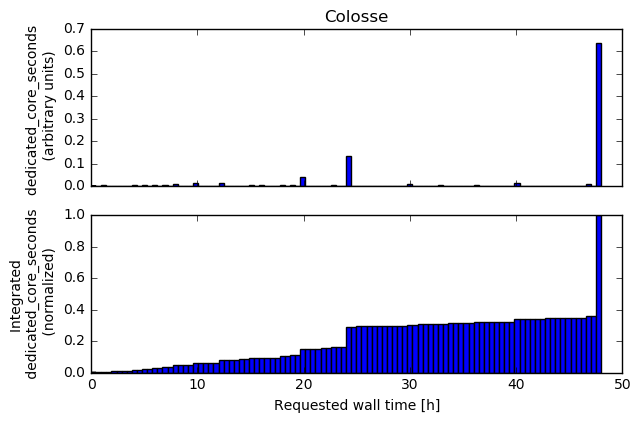

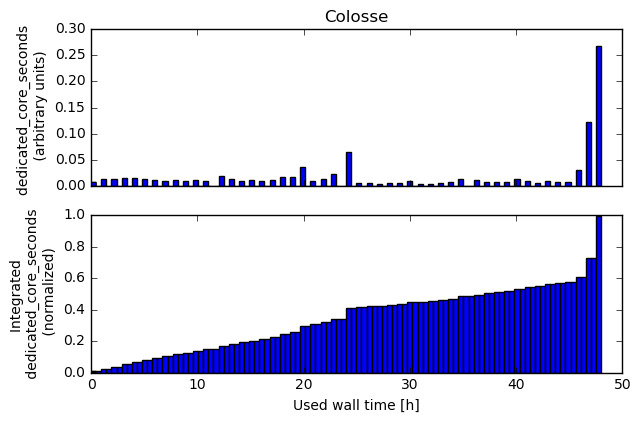

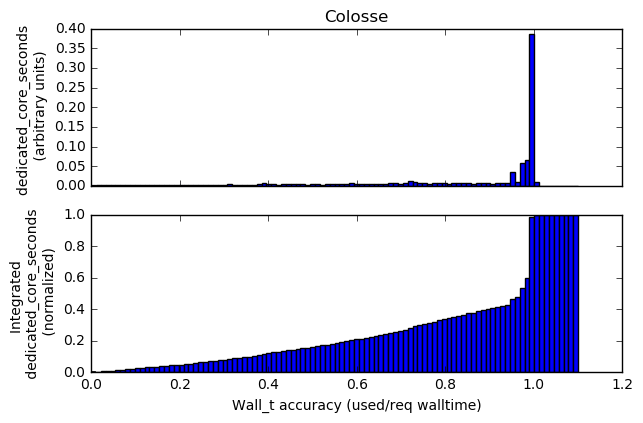

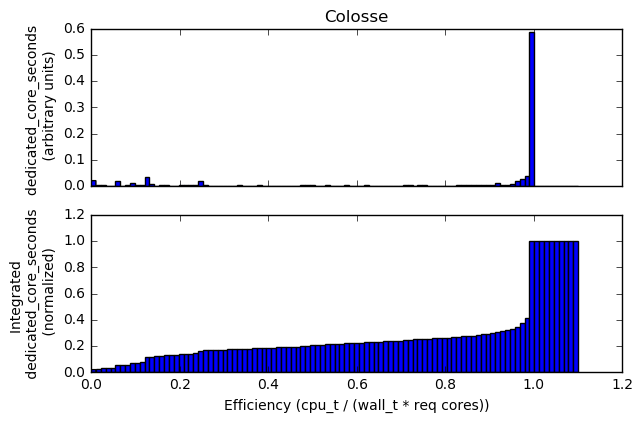

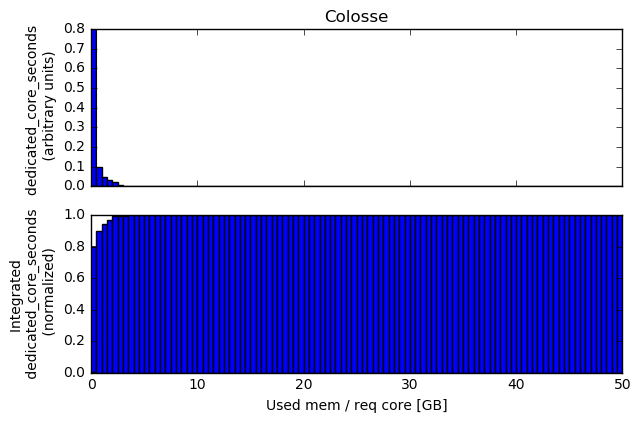

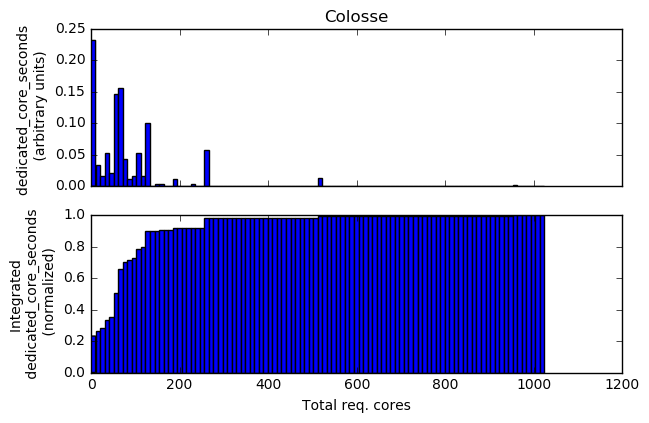

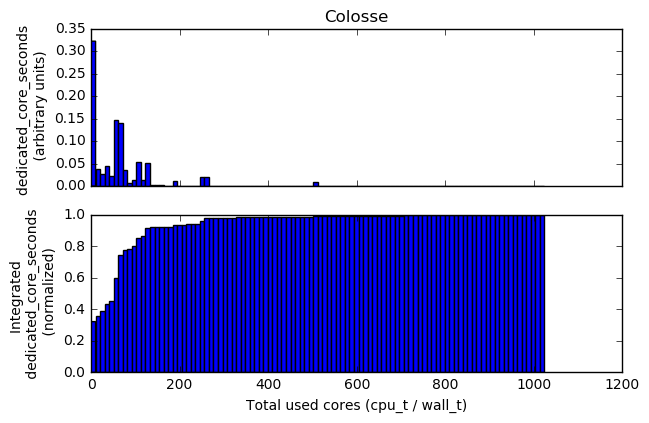

Overall took:33.21651268005371 seconds


In [14]:
import time
start = time.time()
generate_plots_from_log_path(path="/scratch/clumeq/analyse_besoins_chercheurs/colosse_logs_2.txt", 
                             server_name="Colosse", 
                             column_accumulate="dedicated_core_seconds", 
                             gpu=False,
                             max_walltime=48,
                             max_cores=512,
                             max_mem_per_core=20
                            )
print("Overall took:" + str(time.time() - start) + " seconds")

# All CPU servers
With Colosse, we had a 1.1 GB dataset. We now turn to the logs of all Calcul Québec clusters. This larger dataset is 33GB in size. It would be simply too large to handle with Pandas, both because of time considerations (it would take 12 hours to get a plot), but also because it would use too much memory. 

--- 
Les logs de Colosse occupaient 1.1 GB d'espace. Nous utilisons maintenant les logs de tous les serveurs de Calcul Québec. Ce dataset est beaucoup plus gros. Il occupe 33 Go d'espace. Il serait tout simplement trop gros pour traiter avec Pandas, d'abord pour des contraintes de temps (ça prendrait 12 heures pour générer les graphiques), mais aussi parce que les données n'entreraient pas en mémoire. 

Reading data
Computing data
Counting
Counted:61513912
Generating graphics


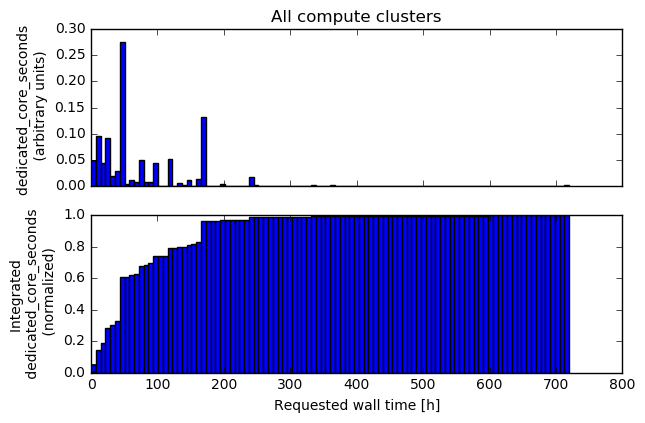

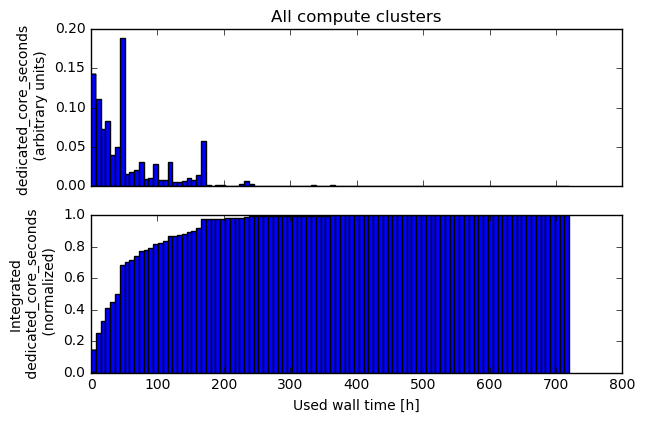

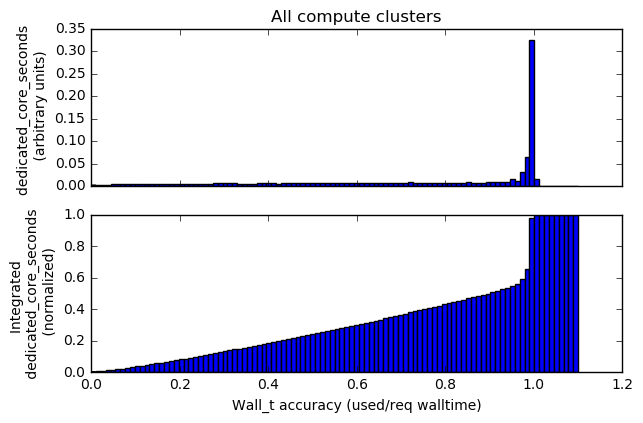

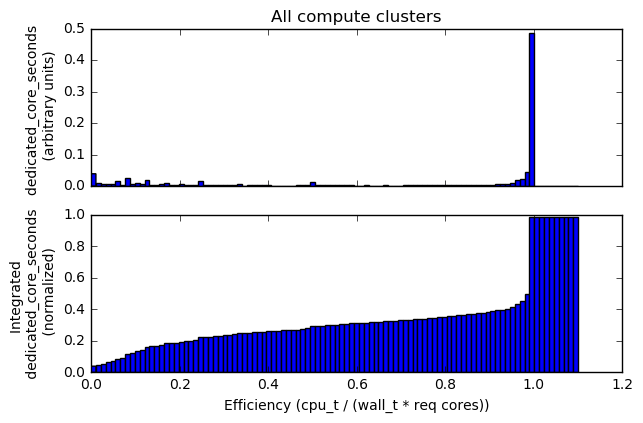

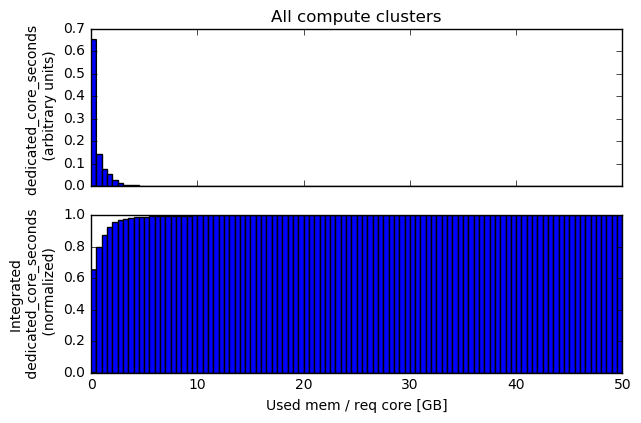

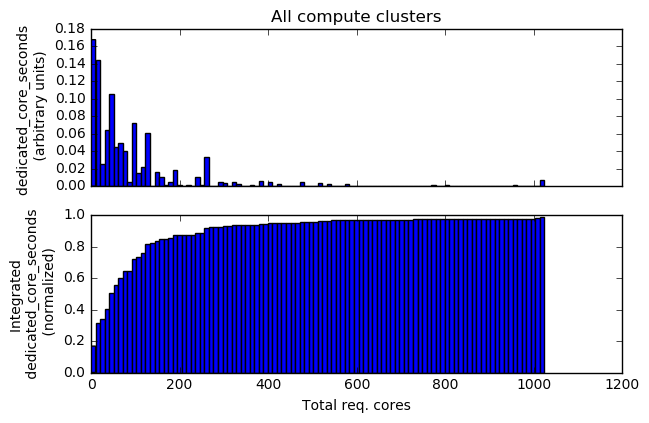

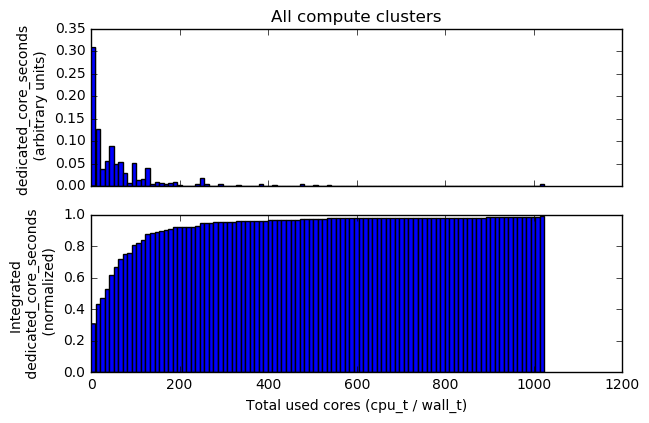

Overall took:420.01835584640503 seconds


In [15]:
start = time.time()
generate_plots_from_log_path(path="/scratch/clumeq/analyse_besoins_chercheurs/all_cpu_clusters.txt", 
                             server_name="All compute clusters", 
                             column_accumulate="dedicated_core_seconds", 
                             gpu=False,
                             max_walltime=720)
print("Overall took:" + str(time.time() - start) + " seconds")

# Performance conclusions - Conclusions relatives à la performance
With Pandas, it took 82 seconds to read the data, 20 minutes to compute the derivated data, and 23 seconds to generate the graphs. This was done on an 8 core machine with 24 GB of memory. However, given that Pandas is not parallelized, a single core was actually used to perform all calculation. This was for a 1.1 GB dataset. 

From around 23 minutes total with Pandas, we went to 33 seconds with Spark. We do not produce the detailed timing of all steps, because timing is hard with Spark because of lazy evaluation: nothing is actually done until you ask for a result (such as a plot). 

Granted, we used more resources (8 nodes instead of 1), but this is still a very interesting gain. Especially when doing interactive analysis. 

Moreover, generating the same plots for 30 times as much data took only 7 minutes. Three times faster for 30 times more data: pretty damn good!

---
Avec Pandas, cela a pris 82 secondes pour lire les données, 20 minutes pour calculer les données dérivées, et 23 secondes pour générer les graphiques. Ceci a été fait sur un serveur à 8 coeurs de calcul avec 24 GB de mémoire. Néanmoins, Pandas n'étant pas parallèle, un seul coeur de calcul a été utilisé pour les calculs. Tout ceci a été fait pour un jeu de données de 1.1Go. 

De 23 minutes avec Pandas, nous avons réduit le temps de calcul à 33 secondes avec Spark. Nous ne montrons pas les temps détaillés de chaque étape, car il est difficile d'avoir ces temps avec Spark. En effet, Spark n'exécute un calcul qu'à partir du moment où un résultat est demandé. 

Nous avons évidemment utilisé davantage de ressources (8 noeuds plutôt qu'un seul), mais c'est tout de même un gain très intéressant. En particulier pour une analyse interactive. 

De plus, générer les mêmes graphiques pour des données 30 fois plus imposantes n'ont nécessité que 7 minutes. Trois fois plus rapide pour 30 fois plus de données: plutôt impressionnant!